# Heatwave risk under the climate change 

### Description of the assessment

This notebook combines the **hazard** Euroheat data[[source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells?tab=overview)] with the **vulnerability data** World pop [[source](https://data.humdata.org/dataset/?dataseries_name=WorldPop%20-%20Age%20and%20sex%20structures&res_format=GeoTIFF&q=&sort=last_modified%20desc&ext_page_size=25)] for the risk estimation for the current and projected climate (rcps 4.5 and 8.5) in the regional resolution for selected EU regions.

**The results provide information about which areas can be more affected by climate change in your chosen country (or area). That means if we get the result that some of the regions are at a very high risk level it does not mean that the risk level is highest among all EU regions, but it means that the regions with very high risk can experience the biggest increase in heat-wave occurrence in the selected country.**  

## Step 1. Preparation work

### Import packages 

:::{admonition} In this notebook we will use the following Python libraries:
:class: hint dropdown
* [os](https://docs.python.org/3/library/os.html) - Handling the current working directory.
* [zipfile](https://docs.python.org/3/library/zipfile.html) - Working with ZIP archive files.
* [glob](https://docs.python.org/3/library/glob.html) - Unix style pathname pattern expansion.
* [pathlib](https://docs.python.org/3/library/pathlib.html) - File system paths.
* [geopandas](https://geopandas.org/en/stable/) - Geospatial data handling.
* [cdsapi](https://cds.climate.copernicus.eu/api-how-to) - Climate Data Store API.
* [xarray](https://docs.xarray.dev/en/stable/) - 2-3D array data handling.
* [rasterio](https://rasterio.readthedocs.io/en/latest/) - NetCDF and raster processing.
* [numpy](https://numpy.org/doc/stable/) - 2-3D array data handling.
* [rasterio.warp](https://rasterio.readthedocs.io/en/latest/topics/reproject.html) - Raster reprojection and resampling.
* [rasterstats](https://pythonhosted.org/rasterstats/) - Zonal statistics for geospatial raster data.
* [matplotlib](https://matplotlib.org/stable/) - Data plotting.
* [rasterio.transform](https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html) - Coordinate transformations for raster data.
:::

In [1]:
import os  # Handling the current working directory.
import zipfile  # Working with ZIP archive files.
import glob  # Unix style pathname pattern expansion.
from pathlib import Path  # File system paths.
import geopandas as gpd  # Geospatial data handling.
import cdsapi  # Climate Data Store API.
import xarray as xr  # 2-3D array data handling.
import rasterio as rio  # NetCDF and raster processing.
import numpy as np  # 2-3D array data handling.
import rasterio  # NetCDF and raster processing.
from rasterio.warp import calculate_default_transform, reproject, Resampling  # Raster reprojection and resampling.
from rasterstats import zonal_stats  # Zonal statistics for geospatial raster data.
import matplotlib.pyplot as plt  # Data plotting.
from rasterio.transform import from_bounds  # Coordinate transformations for raster data.
import rasterstats  # Zonal statistics for geospatial raster data.
from mpl_toolkits.axes_grid1 import make_axes_locatable # Data plotting.
from matplotlib.colors import ListedColormap # Data plotting.
import geopandas as gpd

In [ ]:
import os
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import xarray as xr
import geopandas as gpd
import numpy as np
from rasterstats import zonal_stats

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import os

### Create a directory structure

In [2]:
# Define the directory for the flashflood workflow preprocess
workflow_folder = 'heatwave_risk_projection'
# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_folder,'data')
results_dir = os.path.join(workflow_folder,'results')
# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(os.path.join(data_dir))
    os.makedirs(os.path.join(results_dir))

## Step 2. Download the administrative borders 

The risk assessment will be provided to resolve the administrative border area that you choose. It is important to realize that the risk assessment is calculated from the 12x12km hazard data, which means that the selection of the smaller areas will not be appropriate. 

1. Download the shp. for your country from [[source](https://gadm.org/download_country.html)]
   - select a country
   - download the "Shapefile"
3. Save it to data_dir

In [24]:
# Use glob to find all zip files containing 'gadm' in their names
zip_files = glob.glob(os.path.join(data_dir, 'gadm*.zip'))

# Loop through each zip file and extract it
for zip_path in zip_files:
    with zipfile.ZipFile(zip_path, 'r') as zObject:
        zObject.extractall(path=data_dir)
        print(f'Extracted {zip_path}')

Extracted heatwave_risk_projection\data\gadm41_SVK_shp.zip


In [3]:
# Use glob to find the shapefile ending with '2.shp' within folders containing 'gadm' in their names
shapefile_pattern = os.path.join(data_dir, '*2.shp')
shapefile_paths = glob.glob(shapefile_pattern)

# Check if any shapefiles were found and read the first one
if shapefile_paths:
    shapefile_path = shapefile_paths[0]  
    gdf1 = gpd.read_file(shapefile_path)

### In case that you want to select a subregion
- you cal select the subregions with this code or **if you want to calculate the risk assessment for the whole country then skip this part.** 
- we recomend this approach for bigger countries

In [5]:
# This code can select the subregion e.g.Cataluna
gdf=gdf1[gdf1["NAME_1"]=='Cataluña']

### In case you want to continue with selected country
- we recomend this approach for smaller coutries

In [4]:
gdf=gdf1

### Plot of the selected region/country

<Axes: >

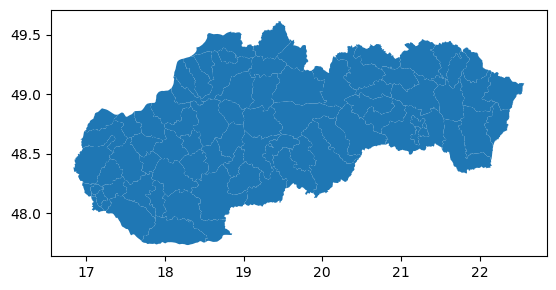

In [5]:
gdf.plot()

### Extract the bounding box for the clipping of the Euroheat and population data 

In [7]:
# Extract the bounding box for the clipping of the Euroheat data
bbox = gdf.total_bounds
# Print the bounding box
print("Bounding Box:", bbox)

Bounding Box: [16.83446148 47.73274612 22.56791306 49.61380005]


## Step 3. Hazard data

**This workflow uses the EuroHEAT hazard data based on the health-related EU-wide definition:** For the summer period of June to August, heat waves were defined as days in which the maximum apparent temperature (Tappmax) exceeds the threshold (90th percentile of Tappmax for each month) and the minimum temperature (Tmin) exceeds its threshold (90th percentile of Tmin for each month) for at least two days. The apparent temperature is a measure of relative discomfort due to combined heat and high humidity, developed based on physiological studies on evaporative skin cooling. It can be calculated as a combination of air and dew point temperature.

- We use this data to provide information about the projected change in the heatwave occurrence for the near future 2016-2045 and further future 2046-2075
- The results are provided in the regional resolution
- In the next steps we are using these data together with the vulnerable population data to estimate projected risk levels for the near and further future.

### Data download
- In this step we downloading the data from the Copernicus Climate Data Store [[source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells?tab=overview)]

In [6]:
URL = "https://cds.climate.copernicus.eu/api/v2"
KEY = "152800:1c6ca43d-189d-48d1-9bef-b571c3f35f34" ### put here your key!!!

In [7]:
# Heat waves and cold spells in Europe derived from climate projections
c = cdsapi.Client(url=URL, key=KEY)
c.retrieve(
    'sis-heat-and-cold-spells',
    {
        'variable': 'heat_wave_days',
        'definition': 'health_related',
        'experiment': [
            'rcp4_5', 'rcp8_5',
        ],
        'ensemble_statistic': [
            'ensemble_members_average', 'ensemble_members_standard_deviation',
        ],
        'format': 'zip',
    },
   f"{data_dir}/heat_spells_health_1986_2085.zip")

2024-07-03 09:00:27,824 INFO Welcome to the CDS
2024-07-03 09:00:27,824 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/sis-heat-and-cold-spells
2024-07-03 09:00:28,162 INFO Request is queued
2024-07-03 09:00:29,230 INFO Request is running
2024-07-03 09:00:49,304 INFO Request is completed
2024-07-03 09:00:49,305 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data2/dataset-sis-heat-and-cold-spells-2aa59166-c154-4aeb-ae36-16a2c9612eb4.zip to heatwave_risk_projection\data/heat_spells_health_1986_2085.zip (161.4M)
2024-07-03 09:01:31,048 INFO Download rate 3.9M/s                                                                      


Result(content_length=169275275,content_type=application/zip,location=https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data2/dataset-sis-heat-and-cold-spells-2aa59166-c154-4aeb-ae36-16a2c9612eb4.zip)

In [17]:
# This code unzips the downloaded files in your working directory, so they will be ready for computing 
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'heat_spells_health_1986_2085.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

###  Extracting the heat occurrence data 
In this step we:
- Extracting the heat occurrence values from data
- Setting of the Coordinate system
- Selecting of the time periods

In [7]:
# This code loads a data form data dir and sets the CRS 
hwd45h = xr.open_dataset(f'{data_dir}/HWD_EU_health_rcp45_mean_v1.0.nc', decode_coords='all')
hwd85h = xr.open_dataset(f'{data_dir}/HWD_EU_health_rcp85_mean_v1.0.nc', decode_coords='all')

hwd45h.rio.write_crs("epsg:4326", inplace=True)
hwd85h.rio.write_crs("epsg:4326", inplace=True)

# This code selects a variable for plotting
hwd45h=hwd45h['HWD_EU_health']
hwd85h=hwd85h['HWD_EU_health']

In [8]:
# Select a time period for maximum temperature
# Max T
hw45h=hwd45h.sel(time=slice("1986-01-01", "2015-12-31"))
hw45p1=hwd45h.sel(time=slice("2016-01-01", "2045-12-31"))
hw45p2=hwd45h.sel(time=slice("2046-01-01", "2075-12-31"))

hw85h=hwd85h.sel(time=slice("1986-01-01", "2015-12-31"))
hw85p1=hwd85h.sel(time=slice("2016-01-01", "2045-12-31"))
hw85p2=hwd85h.sel(time=slice("2046-01-01", "2075-12-31"))

### Calculation of the mean values for historical and projection periods

- This step calculates the mean values for the selected historical and projections time periods

In [9]:
### Calculates the mean values for the selected time periods and clips data to shp. bbox 
# 45 mean
# 1986-2015
hw45hc=hw45h.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])
hw45hc= hw45hc.mean(dim='time', skipna=True, keep_attrs=True)
hw45hc.rio.to_raster(raster_path=f'{data_dir}/hw45hc.tif')
# 2016-2045
hw45p1c=hw45p1.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])
hw45p1c= hw45p1c.mean(dim='time', skipna=True, keep_attrs=True)
hw45p1c.rio.to_raster(raster_path=f'{data_dir}/hw45p1c.tif')
# 2046-2075
hw45p2c=hw45p2.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])
hw45p2c= hw45p2c.mean(dim='time', skipna=True, keep_attrs=True)
hw45p2c.rio.to_raster(raster_path=f'{data_dir}/hw45p2c.tif')
# 85 mean
# 1986-2015
hw85hc=hw85h.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])
hw85hc= hw85hc.mean(dim='time', skipna=True, keep_attrs=True)
hw85hc.rio.to_raster(raster_path=f'{data_dir}/hw85hc.tif')
# 2016-2045
hw85p1c=hw85p1.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])
hw85p1c= hw85p1c.mean(dim='time', skipna=True, keep_attrs=True)
hw85p1c.rio.to_raster(raster_path=f'{data_dir}/hw85p1c.tif')
# 2046-2075
hw85p2c=hw85p2.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])
hw85p2c= hw85p2c.mean(dim='time', skipna=True, keep_attrs=True)
hw85p2c.rio.to_raster(raster_path=f'{data_dir}/hw85p2c.tif')

### Relative change of the heatwave occurence 

In [10]:
# This code calculates the relative change in the heatwave occurrence and calculates the zonal statistic based on the imported regions shp. 
# Paths to the data directory and shapefile
#data_dir = '/mnt/data'
shapefile_path = f'{data_dir}/gadm41_SVK_2.shp'

# Load the raster data
hw45hc = xr.open_dataset(f'{data_dir}/hw45hc.tif')['band_data']
hw45p1c = xr.open_dataset(f'{data_dir}/hw45p1c.tif')['band_data']
hw45p2c = xr.open_dataset(f'{data_dir}/hw45p2c.tif')['band_data']
hw85hc = xr.open_dataset(f'{data_dir}/hw85hc.tif')['band_data']
hw85p1c = xr.open_dataset(f'{data_dir}/hw85p1c.tif')['band_data']
hw85p2c = xr.open_dataset(f'{data_dir}/hw85p2c.tif')['band_data']

# Calculate relative change for RCP 4.5
relative_change_45_p1 = ((hw45p1c - hw45hc) / hw45hc) * 100
relative_change_45_p2 = ((hw45p2c - hw45hc) / hw45hc) * 100

# Calculate relative change for RCP 8.5
relative_change_85_p1 = ((hw85p1c - hw85hc) / hw85hc) * 100
relative_change_85_p2 = ((hw85p2c - hw85hc) / hw85hc) * 100

# Function to ensure the correct shape for raster writing
def save_relative_change_as_raster(relative_change, reference_raster_path, output_path):
    with rasterio.open(reference_raster_path) as src:
        meta = src.meta.copy()
        meta.update(dtype=rasterio.float32, count=1)
        
        # Ensure relative_change is a 2D array
        relative_change_2d = np.squeeze(relative_change.values)
        
        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(relative_change_2d.astype(rasterio.float32), 1)

# Save the relative change rasters using the correct function
save_relative_change_as_raster(relative_change_45_p1, f'{data_dir}/hw45hc.tif', f'{data_dir}/relative_change_45_p1.tif')
save_relative_change_as_raster(relative_change_45_p2, f'{data_dir}/hw45hc.tif', f'{data_dir}/relative_change_45_p2.tif')
save_relative_change_as_raster(relative_change_85_p1, f'{data_dir}/hw85hc.tif', f'{data_dir}/relative_change_85_p1.tif')
save_relative_change_as_raster(relative_change_85_p2, f'{data_dir}/hw85hc.tif', f'{data_dir}/relative_change_85_p2.tif')

# List of relative change raster files
relative_change_rasters = [
    f'{data_dir}/relative_change_45_p1.tif',
    f'{data_dir}/relative_change_45_p2.tif',
    f'{data_dir}/relative_change_85_p1.tif',
    f'{data_dir}/relative_change_85_p2.tif'
]

# Define the target CRS (WGS84 EPSG:4326)
target_crs = "EPSG:4326"

# Function to reproject raster to a target CRS
def reproject_raster(raster_path, target_crs):
    with rasterio.open(raster_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        reprojected_raster_path = raster_path.replace(".tif", "_reprojected.tif")

        with rasterio.open(reprojected_raster_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest
                )

    return reprojected_raster_path

# Reproject rasters
reprojected_relative_change_rasters = [reproject_raster(raster, target_crs) for raster in relative_change_rasters]

# Load your shapefile and reproject it to the target CRS
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs(target_crs)

# Function to calculate zonal statistics and save to shapefile
def calculate_and_save_zonal_stats(gdf, raster, output_path):
    stats = zonal_stats(gdf, raster, stats="mean", all_touched=True)
    # Handle None values
    mean_values = [round(s['mean']) if s['mean'] is not None else 0 for s in stats]
    gdf_temp = gdf.copy()
    gdf_temp[f"{os.path.basename(raster).replace('.tif', '')}_mean"] = mean_values
    gdf_temp.to_file(output_path)

# Calculate zonal statistics for each reprojected raster
for raster in reprojected_relative_change_rasters:
    output_shapefile_path = f"{data_dir}/{os.path.basename(raster).replace('.tif', '_zonal_stats.shp')}"
    calculate_and_save_zonal_stats(gdf, raster, output_shapefile_path)

C:\Users\MartinKuban\anaconda3\envs\cordex\Lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
C:\Users\MartinKuban\AppData\Local\Temp\ipykernel_15420\3024356569.py:101: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_temp.to_file(output_path)
C:\Users\MartinKuban\AppData\Local\Temp\ipykernel_15420\3024356569.py:101: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_temp.to_file(output_path)
C:\Users\MartinKuban\AppData\Local\Temp\ipykernel_15420\3024356569.py:101: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_temp.to_file(output_path)
C:\Users\MartinKuban\AppData\Local\Temp\ipykernel_15420\3024356569.py:101: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_temp.to_file(output_path)


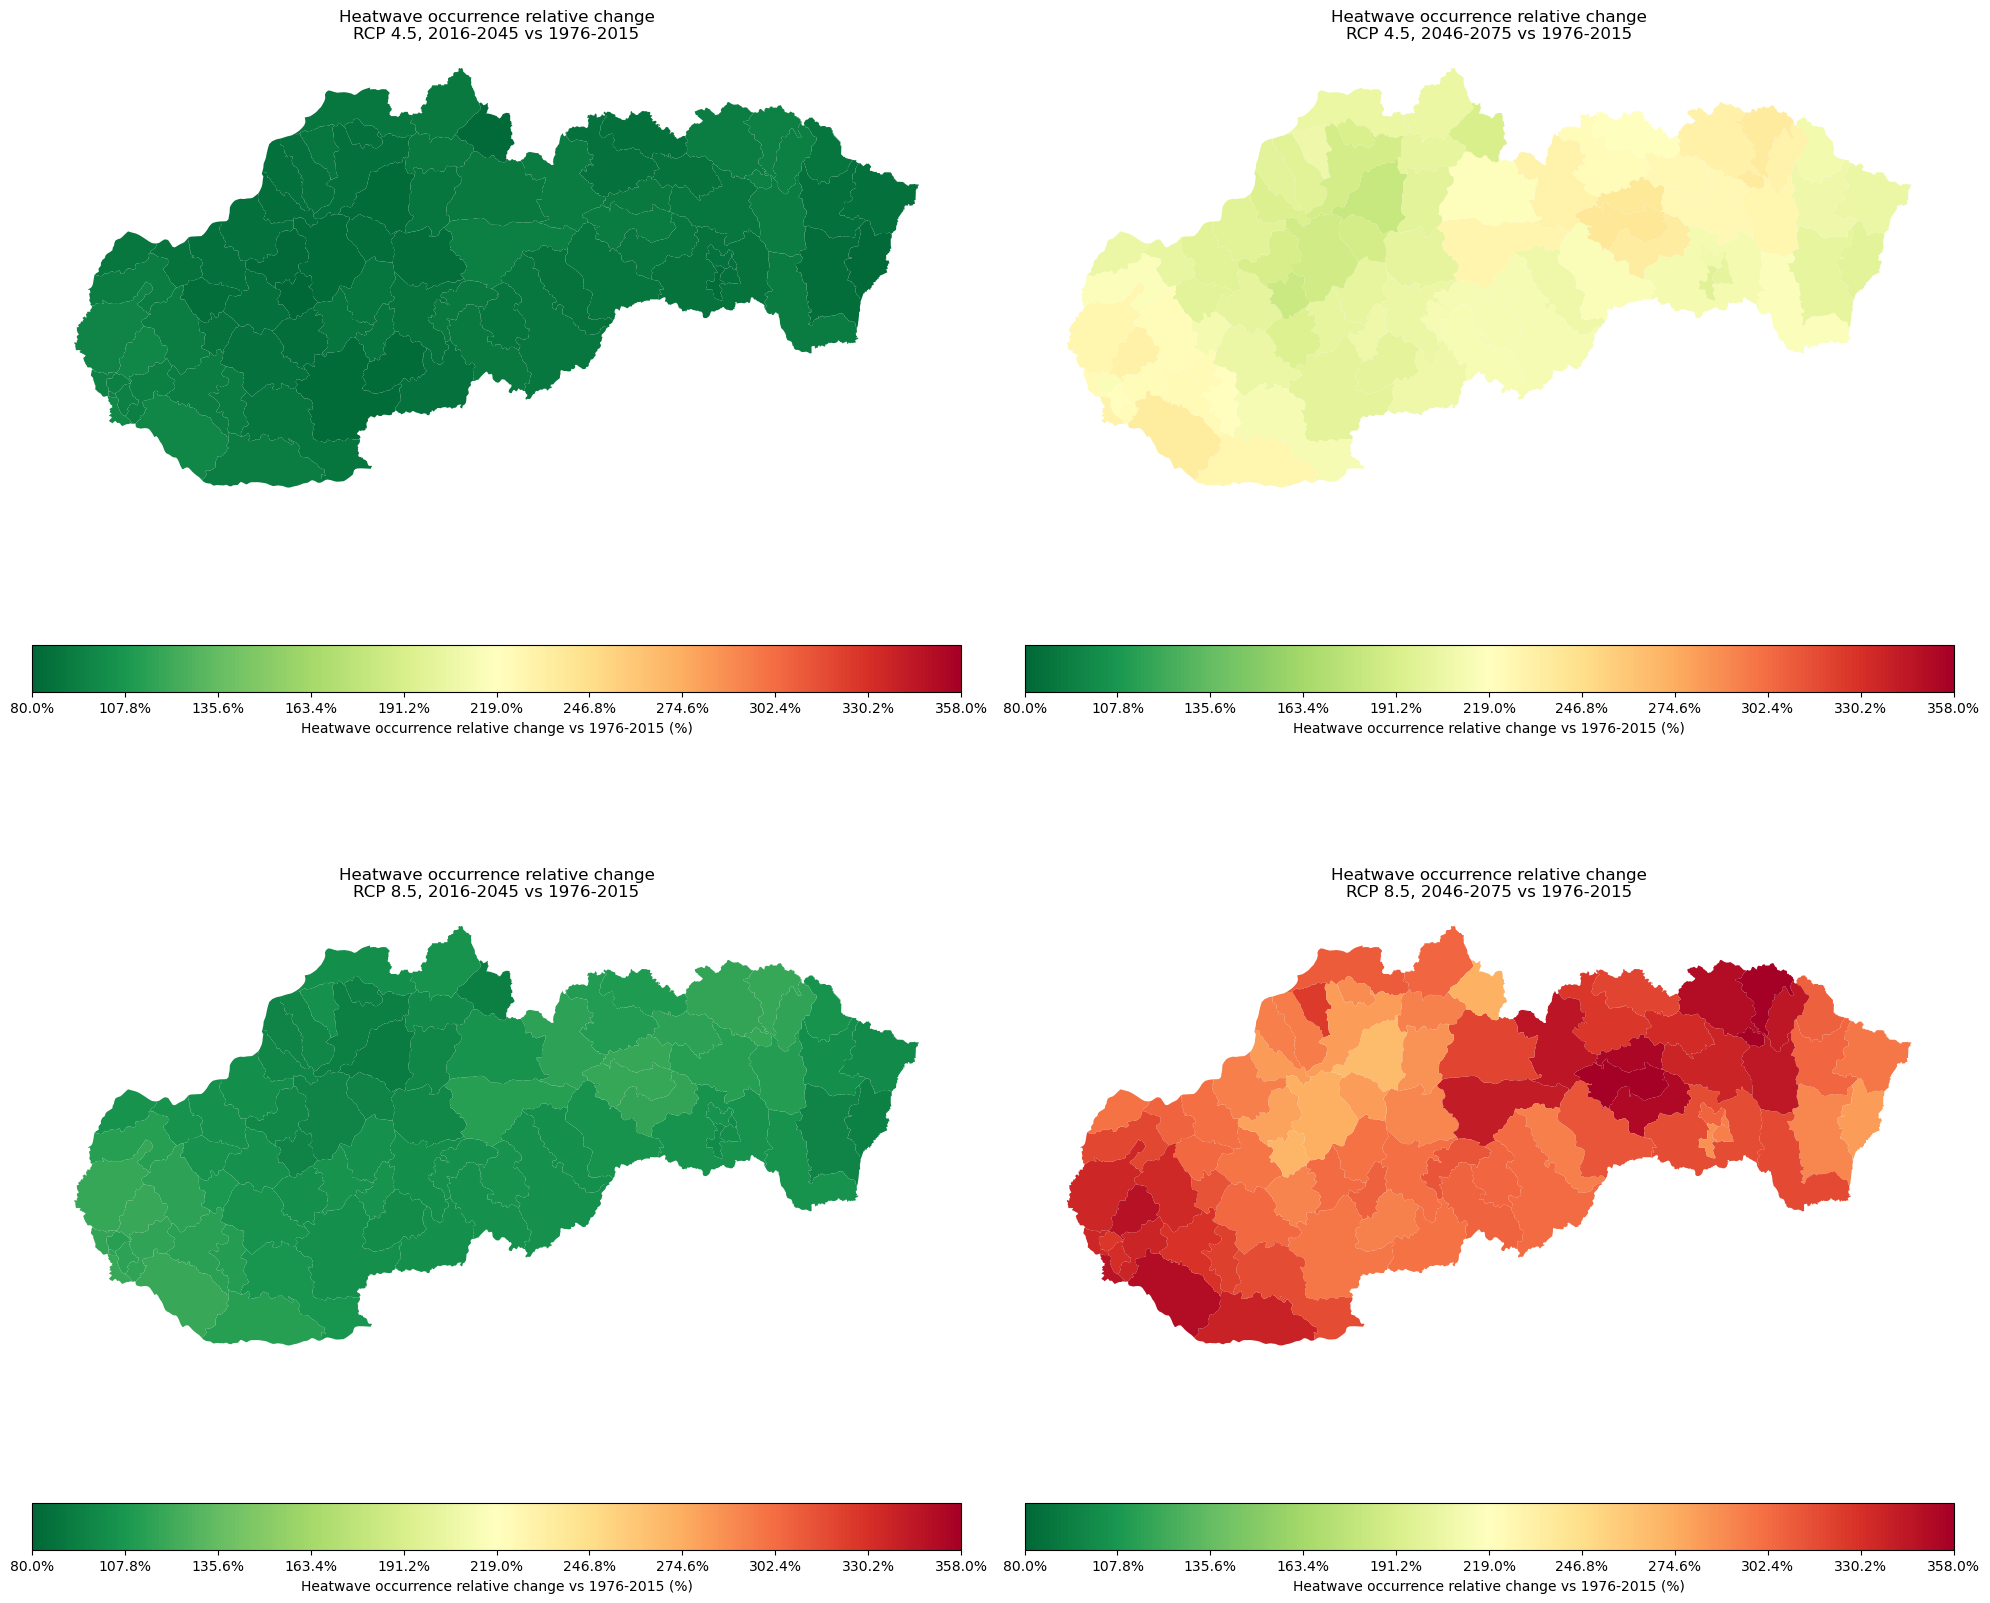

In [10]:
# This code plots the relative change of the heatwave occurrence 

# Paths to the reprojected zonal statistics shapefiles
zonal_stats_files = [
    f'{data_dir}/relative_change_45_p1_reprojected_zonal_stats.shp',
    f'{data_dir}/relative_change_45_p2_reprojected_zonal_stats.shp',
    f'{data_dir}/relative_change_85_p1_reprojected_zonal_stats.shp',
    f'{data_dir}/relative_change_85_p2_reprojected_zonal_stats.shp'
]

# Corresponding titles for the plots and filenames for saving
titles = [
    'Heatwave occurrence relative change\nRCP 4.5, 2016-2045 vs 1976-2015',
    'Heatwave occurrence relative change\nRCP 4.5, 2046-2075 vs 1976-2015',
    'Heatwave occurrence relative change\nRCP 8.5, 2016-2045 vs 1976-2015',
    'Heatwave occurrence relative change\nRCP 8.5, 2046-2075 vs 1976-2015'
]

output_filenames = [
    'relative_change_rcp45_2016_2045.shp',
    'relative_change_rcp45_2046_2075.shp',
    'relative_change_rcp85_2016_2045.shp',
    'relative_change_rcp85_2046_2075.shp'
]

# Load all shapefiles into a list of GeoDataFrames
gdfs = [gpd.read_file(file) for file in zonal_stats_files]

# Function to find the column containing 'mean' in the name
def find_mean_column(gdf):
    for col in gdf.columns:
        if 'relative' in col:
            return col
    return None

# Get the column names for all GeoDataFrames
mean_columns = [find_mean_column(gdf) for gdf in gdfs]

# Filter out any None values (in case some GeoDataFrames don't have a 'mean' column)
filtered_gdfs = [(gdf, col) for gdf, col in zip(gdfs, mean_columns) if col is not None]

# Get the global min and max of the relative change values
min_value = min(gdf[col].min() for gdf, col in filtered_gdfs)
max_value = max(gdf[col].max() for gdf, col in filtered_gdfs)

# Define the class intervals and labels for relative change
class_intervals = np.linspace(min_value, max_value, 11)
class_labels = ['%.1f%%' % val for val in class_intervals]

# Initialize lists to combine GeoDataFrames
combined_gdfs = [gpd.GeoDataFrame() for _ in range(4)]

# Plot each shapefile and save them
fig, axes = plt.subplots(2, 2, figsize=(20, 18))  # 2 rows and 2 columns for the 4 plots
axes = axes.flatten()

for i, (ax, (gdf, col), title, output_filename) in enumerate(zip(axes, filtered_gdfs, titles, output_filenames)):
    # Plot the map
    gdf.plot(column=col, ax=ax, legend=True,
             legend_kwds={'label': "Heatwave occurrence relative change vs 1976-2015 (%)",
                          'orientation': "horizontal",
                          'ticks': class_intervals,
                          'spacing': 'uniform',
                          'format': lambda x, _: class_labels[class_intervals.tolist().index(x)] if x in class_intervals else ''},
             vmin=min_value, vmax=max_value, cmap='RdYlGn_r')
    ax.set_title(title)
    ax.axis('off')
    
    # Append the current GeoDataFrame to the combined list
    combined_gdfs[i] = gdf[[col, 'geometry']].copy()

    # Save each combined GeoDataFrame as a new shapefile
    output_path = os.path.join(results_dir, output_filename)
    combined_gdfs[i].to_file(output_path)

plt.tight_layout()
plt.show()


### Magnitude of change in the heatwave occurrence 
- This step reclassifies the heatwave occurrence relative change data into 10 equal interval classes. We need this to use the data in the 10+10 risk matrix (in the next steps)
- the result is the magnitude of change in the heatwave occurrence classified from 1 to 10 (1-very low change, 10-very high change) see the picture above percentual expression

Global Minimum Relative Change: 80%
Global Maximum Relative Change: 358%
Unique classes in heatwave_risk_projection\results/relative_change_rcp45_2016_2045.shp: [1 0]
Unique classes in heatwave_risk_projection\results/relative_change_rcp45_2046_2075.shp: [5 6 4]
Unique classes in heatwave_risk_projection\results/relative_change_rcp85_2016_2045.shp: [1 2]
Unique classes in heatwave_risk_projection\results/relative_change_rcp85_2046_2075.shp: [ 8  9 10  7]


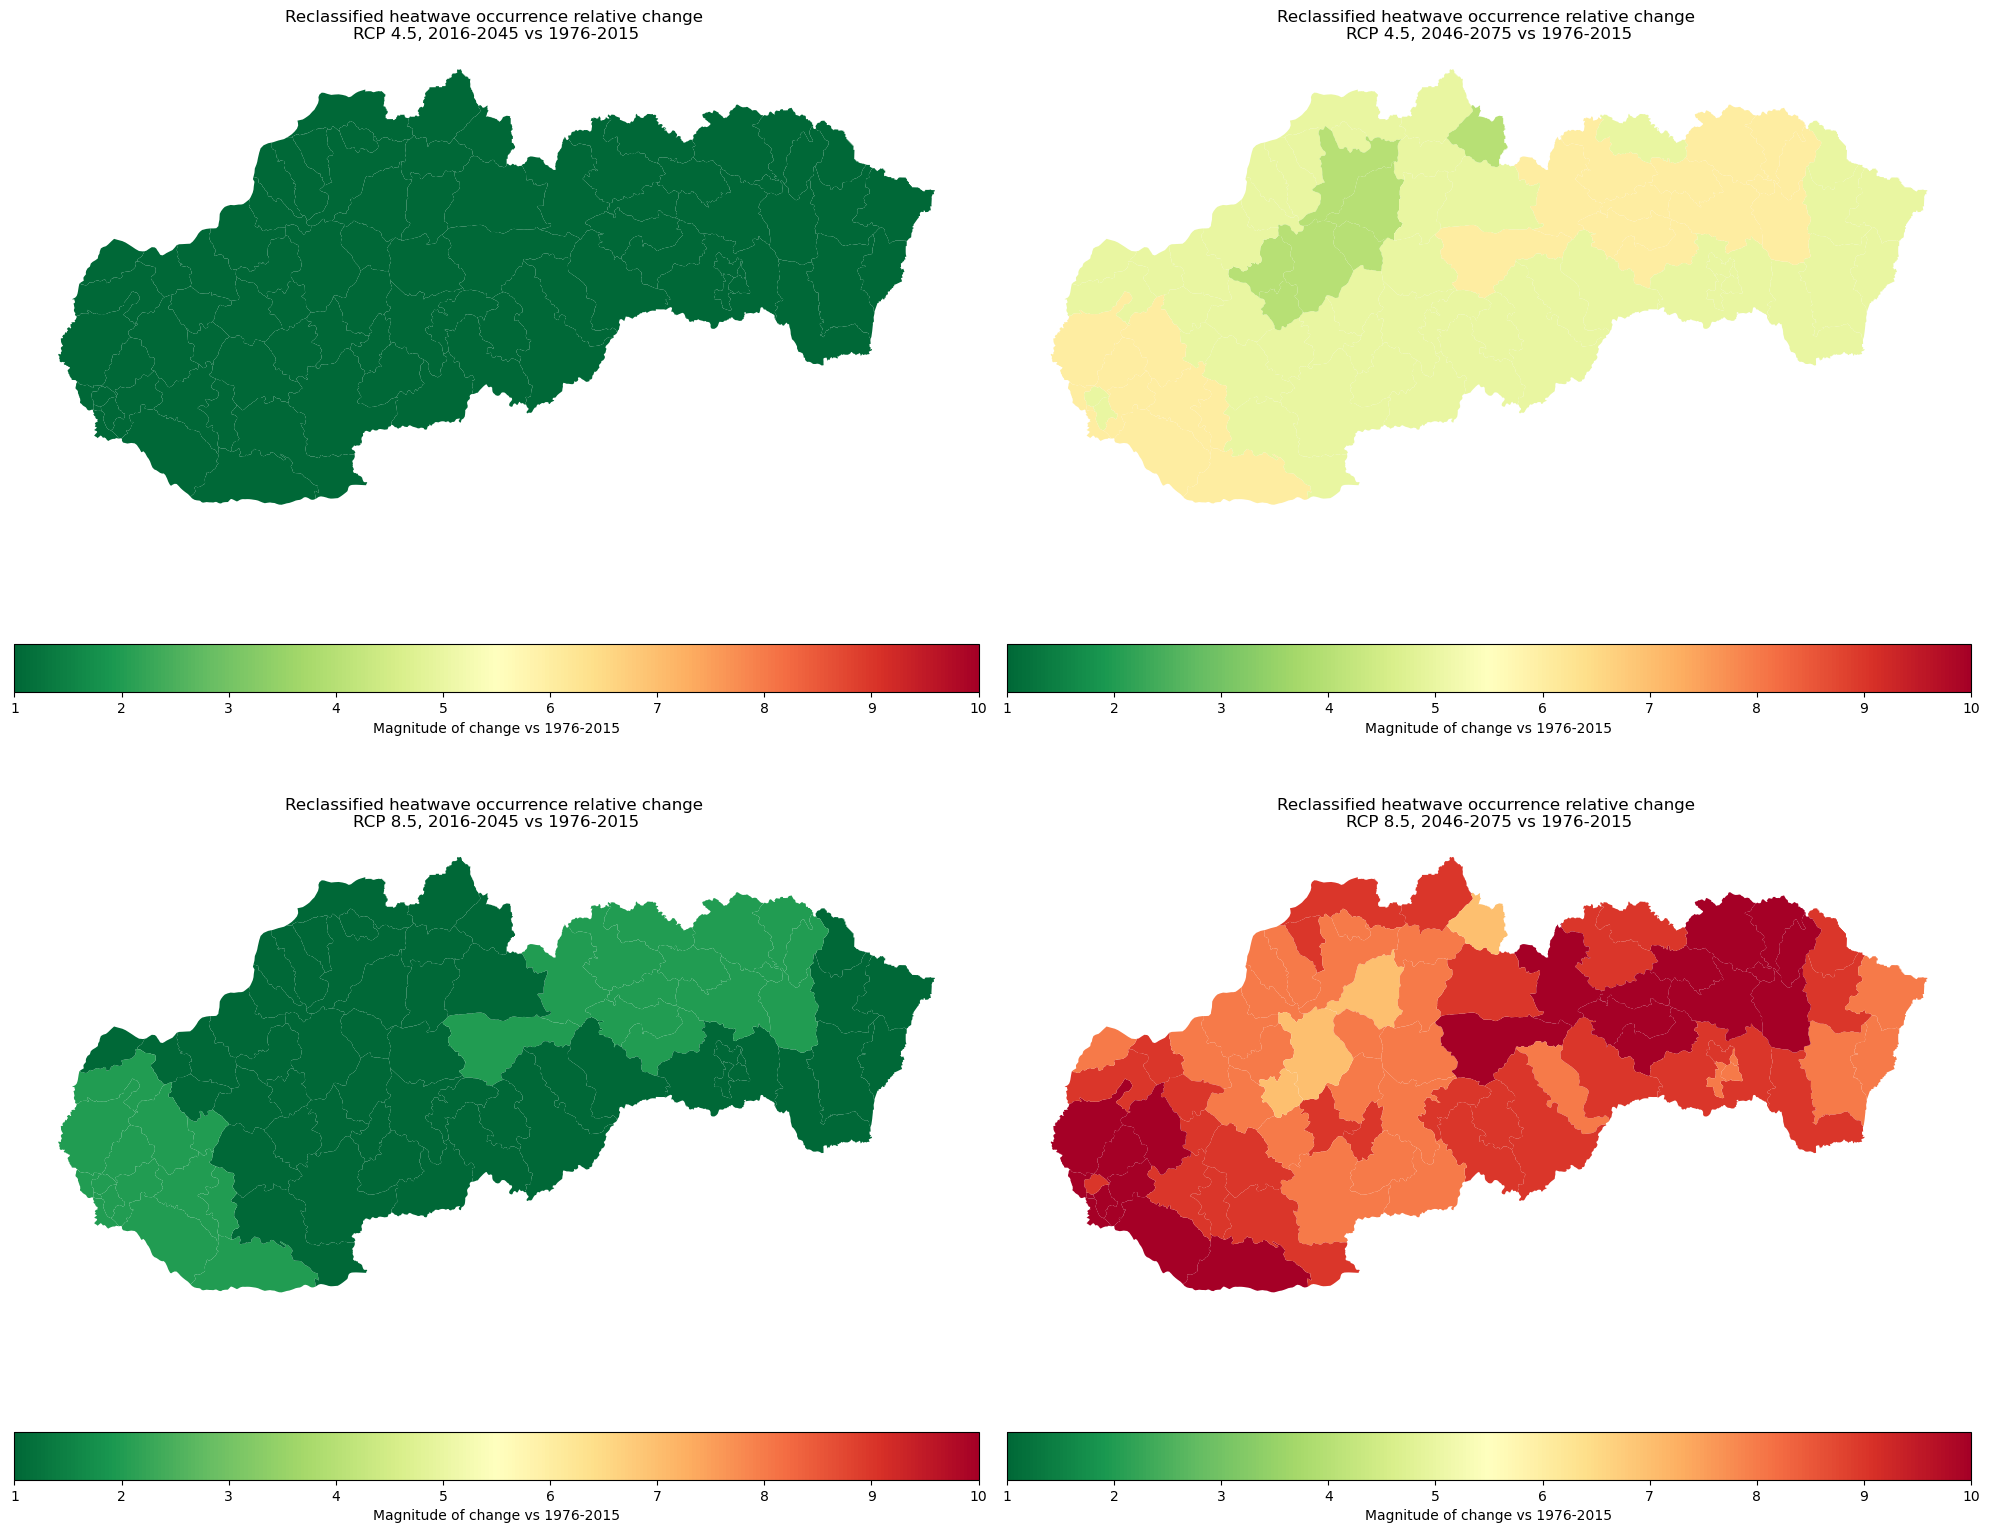

In [18]:
# This code reclassifies the heatwave occurrence relative change data in to 10 equal intervals

# Paths to the shapefiles
shapefiles = [
    f'{results_dir}/relative_change_rcp45_2016_2045.shp',
    f'{results_dir}/relative_change_rcp45_2046_2075.shp',
    f'{results_dir}/relative_change_rcp85_2016_2045.shp',
    f'{results_dir}/relative_change_rcp85_2046_2075.shp'
]

# Corresponding titles for the plots
titles = [
    'Reclassified heatwave occurrence relative change \nRCP 4.5, 2016-2045 vs 1976-2015',
    'Reclassified heatwave occurrence relative change \nRCP 4.5, 2046-2075 vs 1976-2015',
    'Reclassified heatwave occurrence relative change \nRCP 8.5, 2016-2045 vs 1976-2015',
    'Reclassified heatwave occurrence relative change \nRCP 8.5, 2046-2075 vs 1976-2015'
]

# Output filenames for reclassified shapefiles
output_filenames = [
    f'{results_dir}/reclassified_relative_change_rcp45_2016_2045.shp',
    f'{results_dir}/reclassified_relative_change_rcp45_2046_2075.shp',
    f'{results_dir}/reclassified_relative_change_rcp85_2016_2045.shp',
    f'{results_dir}/reclassified_relative_change_rcp85_2046_2075.shp'
]

# Function to find the column containing 'relative' in the name
def find_relative_column(gdf):
    for col in gdf.columns:
        if 'relative' in col:
            return col
    return None

# First, determine the global min and max across all shapefiles
global_min = np.inf
global_max = -np.inf

for shapefile_path in shapefiles:
    gdf = gpd.read_file(shapefile_path)
    relative_col = find_relative_column(gdf)
    if relative_col:
        min_value = gdf[relative_col].min()
        max_value = gdf[relative_col].max()
        global_min = min(global_min, min_value)
        global_max = max(global_max, max_value)

# Print the global minimum and maximum values
print(f"Global Minimum Relative Change: {global_min}%")
print(f"Global Maximum Relative Change: {global_max}%")

# Define the class intervals based on the global min and max
class_intervals = np.linspace(global_min, global_max, 11)

# Create a 2x2 plot grid
fig, axes = plt.subplots(2, 2, figsize=(20, 16))  # 2 rows, 2 columns

# Flatten the axes array to easily iterate over it
axes = axes.flatten()

# Process each shapefile with the determined class intervals
for i, (shapefile_path, title, output_path) in enumerate(zip(shapefiles, titles, output_filenames)):
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Identify the column containing the relative change
    relative_col = find_relative_column(gdf)

    if relative_col is None:
        raise ValueError(f"No 'relative' column found in the GeoDataFrame for {shapefile_path}.")

    # Reclassify the data according to the global class intervals
    gdf['class'] = np.digitize(gdf[relative_col], class_intervals, right=True)

    # Print the unique classes to check the distribution
    print(f"Unique classes in {shapefile_path}: {gdf['class'].unique()}")

    # Plot the reclassified data on the corresponding subplot
    gdf.plot(column='class', ax=axes[i], legend=True,
             legend_kwds={
                 'label': "Magnitude of change vs 1976-2015",
                 'orientation': "horizontal",
                 'ticks': np.arange(1, 11),  # Set ticks from 1 to 10
                 'format': lambda x, _: f'{int(x)}'  # Format ticks as integers
             },
             cmap='RdYlGn_r',
             vmin=1, vmax=10)  # Ensure color mapping from 1 to 10

    axes[i].set_title(title)
    axes[i].axis('off')

    # Save the reclassified shapefile
    gdf.to_file(output_path)

# Adjust layout
plt.tight_layout()
plt.show()


The picture above represents the magnitude of potential projected increase of the heatwave occurence among the selected regions from 1 to 10 (1-very low change, 10-very high change) 

## Step 4. Vulnerable population data


- In this step, we are using the grided 100x100m vulnerable population data, which helps to identify the most vulnerable places in terms of human health.  

 1. In the link **[[Source](https://data.humdata.org/dataset/?dataseries_name=WorldPop%20-%20Age%20and%20sex%20structures&groups=esp&res_format=GeoTIFF&q=&sort=last_modified%20desc&ext_page_size=25)]**:
       -  Select the **WorldPop-Age and sex structures**
       -  Select the **Location**
       -  Select the **Formats** to GeoTIFF.
         
 2. Download the maps for the most vulnerable groups of the population **e.g for Slovakia: svk_m(f)_65(1,70, 75, 80)_2020.tif**. Save the data in the data_dir where you create a folder **population** and save it there.
    
 4. svk_m_1_2020.tif =
     -  svk = Slovakia
     -  m = male, download also for f = female
     -  1 = 1 to 5 years of age, download also for 65, 70, 75, 80
     -  2020 = age structures in 2020
       
 5. When you download all these maps to the Heat-workflow data folder you  can use this code for data handling:
    - in the first step we load all the maps of the critical population 
    - then we calculate the sum of the vulnerable population from each of the maps
    - we classified the maps into 10 groups (equal intervals)
    - plot it next to a map of overheated areas.

### Extraction of the data
- In this steps we extracts the vulnerable population data and sum values for all vulnerable groups of population

In [9]:
# This code loads all population data and creates a raster stack from them 
poplist = glob.glob( f'{data_dir}/population/*.tif')
#
with rasterio.open(poplist[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(poplist))
#
with rasterio.open(f'{data_dir}/Population_raster_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(poplist, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

In [10]:
pop_path = f'{data_dir}/Population_raster_stack.tif'
pop = xr.open_dataset(pop_path)
pop = pop.sum(dim='band', skipna=True, keep_attrs=True)
pop = pop['band_data']
pop.rio.to_raster(raster_path=f'{data_dir}/pop_sum.tif')

### Reclassifies the vulnerable population data and calculates the zonal statistics

- In this step we reclassify the vulnerable population data to 10 equal interval groups fo the use in the 10+10 risk matrix with the projected magnitude of change in the heatwave occurrence.

In [18]:
# this code reclassify the vulnerable population data to 10 equal interval and calculates the zonal statistic for selected regions
# Load the shapefile
gdf=gdf1
regions = gdf

# Load the raster data
raster_path = os.path.join(data_dir, 'pop_sum.tif')
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)
    transform = src.transform
    crs = src.crs

# Mask out values <= 1
raster_data = np.where(raster_data > 1, raster_data, np.nan)

# Save the masked raster to a temporary file to use with rasterstats
masked_raster_path = os.path.join(data_dir, 'masked_pop_sum.tif')
with rasterio.open(
    masked_raster_path, 'w',
    driver='GTiff',
    height=raster_data.shape[0],
    width=raster_data.shape[1],
    count=1,
    dtype=rasterio.float32,
    crs=crs,
    transform=transform
) as dst:
    dst.write(raster_data, 1)

# Calculate the zonal statistics
stats = rasterstats.zonal_stats(regions, masked_raster_path, stats="mean", geojson_out=True)
regions_stats = gpd.GeoDataFrame.from_features(stats)

# Extract the mean density values
if 'mean' in regions_stats.columns:
    regions_stats['mean_density'] = regions_stats['mean']
else:
    regions_stats['mean_density'] = regions_stats['properties'].apply(lambda x: x['mean'])

# Determine the class intervals based on the density
num_classes = 10
class_intervals = np.linspace(regions_stats['mean_density'].min(), regions_stats['mean_density'].max(), num_classes + 1)

# Classify the densities
def classify_density(density, class_intervals):
    for i in range(len(class_intervals) - 1):
        if class_intervals[i] <= density < class_intervals[i + 1]:
            return i + 1
    return num_classes

regions_stats['density_class'] = regions_stats['mean_density'].apply(lambda x: classify_density(x, class_intervals))

# Merge with original regions to retain 'NAME_2'
regions_stats = regions_stats.merge(regions[['NAME_2', 'geometry']], on='geometry')

# Save the results to a new shapefile
output_shapefile_path = os.path.join(results_dir, 'population_classified_regions.shp')
regions_stats.to_file(output_shapefile_path)


C:\Users\MartinKuban\AppData\Local\Temp\ipykernel_15536\1945325875.py:57: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  regions_stats.to_file(output_shapefile_path)


### Plots the zonal statistics for the vulnerable population data

C:\Users\MartinKuban\AppData\Local\Temp\ipykernel_22672\70542218.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r', 10)


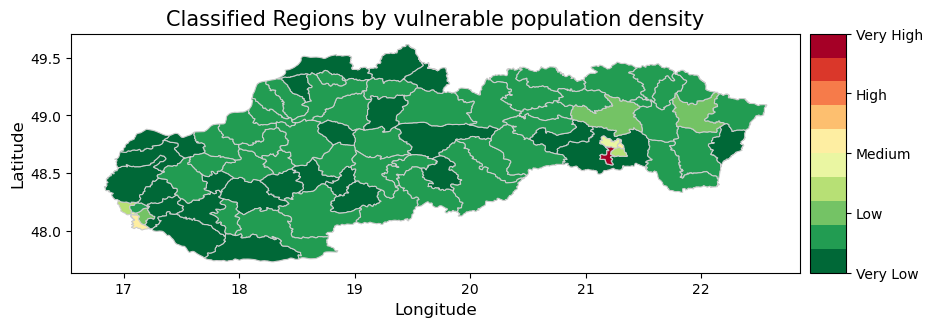

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
# Load the classified regions shapefile
classified_shapefile_path = f'{results_dir}/population_classified_regions.shp'
classified_regions = gpd.read_file(classified_shapefile_path)
# Define a colormap
cmap = plt.cm.get_cmap('RdYlGn_r', 10)
# Plot the classified regions
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
classified_regions.plot(column='density_cl', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)
# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=10))
sm._A = []  # Empty array for the scalar mappable
cbar = fig.colorbar(sm, cax=cax, ticks=[1, 3.25, 5.5, 7.75, 10])
# Set the colorbar labels
cbar.ax.set_yticklabels(['Very Low', 'Low', 'Medium', 'High', 'Very High'], size=10)
# Set plot title and labels
ax.set_title('Classified Regions by vulnerable population density', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
# Show the plot
plt.show()

## Step 5. Estimation of magnitude of  heatwave risk change for the vulnerable population

- For the risk estimation we used the 10+10 risk matrix, which combines the **heatwave occurence hazard data with vulnerable population data**

![heatwave ilustration](https://github.com/CLIMAAX/HEATWAVES/blob/main/Images/risk_matrix_10by10_projections.png?raw=true "Risk matrix example")

### Calculate the risk values based on the risk matrix

- **In this step we combine the magnitude of change in the heatwave occurrence with the vulnerable population density**

- In this step we combinates the reclassified **hazard** and **vulnerable population** data to highlight each region's risk level.

In [20]:
import geopandas as gpd
import os  

# Paths to the shapefiles
zonal_stats_paths = [
    ('reclassified_relative_change_rcp45_2016_2045.shp', 'class'),
    ('reclassified_relative_change_rcp45_2046_2075.shp', 'class'),
    ('reclassified_relative_change_rcp85_2016_2045.shp', 'class'),
    ('reclassified_relative_change_rcp85_2046_2075.shp', 'class')
]

classified_regions_path = os.path.join(results_dir, 'population_classified_regions.shp')

# Load the classified regions shapefile
classified_regions = gpd.read_file(classified_regions_path)

# Check if CRS is defined for classified regions, and set it if missing
if classified_regions.crs is None:
    classified_regions.set_crs(epsg=4326, inplace=True)

crs_classified = classified_regions.crs

for file_name, column_name in zonal_stats_paths:
    # Load the zonal stats shapefile
    zonal_stats_path = os.path.join(results_dir, file_name)
    zonal_gdf = gpd.read_file(zonal_stats_path)
    
    # Check if CRS is defined for zonal stats and set it if missing
    if zonal_gdf.crs is None:
        zonal_gdf.set_crs(epsg=4326, inplace=True)
    
    # Check CRS and reproject if necessary
    if zonal_gdf.crs != crs_classified:
        zonal_gdf = zonal_gdf.to_crs(crs_classified)
    
    # Merge the columns
    merged_gdf = classified_regions.copy()
    merged_gdf[column_name] = zonal_gdf[column_name]
    merged_gdf['sum_class'] = merged_gdf['density_cl'] + merged_gdf[column_name]
    
    # Save the resulting shapefile
    output_path = os.path.join(results_dir, f'sum_class_{file_name}')
    merged_gdf.to_file(output_path)
    print(f"Saved {output_path}")

print("All shapefiles with sum_class created successfully.")


Saved heatwave_risk_projection\results\sum_class_reclassified_relative_change_rcp45_2016_2045.shp
Saved heatwave_risk_projection\results\sum_class_reclassified_relative_change_rcp45_2046_2075.shp
Saved heatwave_risk_projection\results\sum_class_reclassified_relative_change_rcp85_2016_2045.shp
Saved heatwave_risk_projection\results\sum_class_reclassified_relative_change_rcp85_2046_2075.shp
All shapefiles with sum_class created successfully.


### Plots the risk map

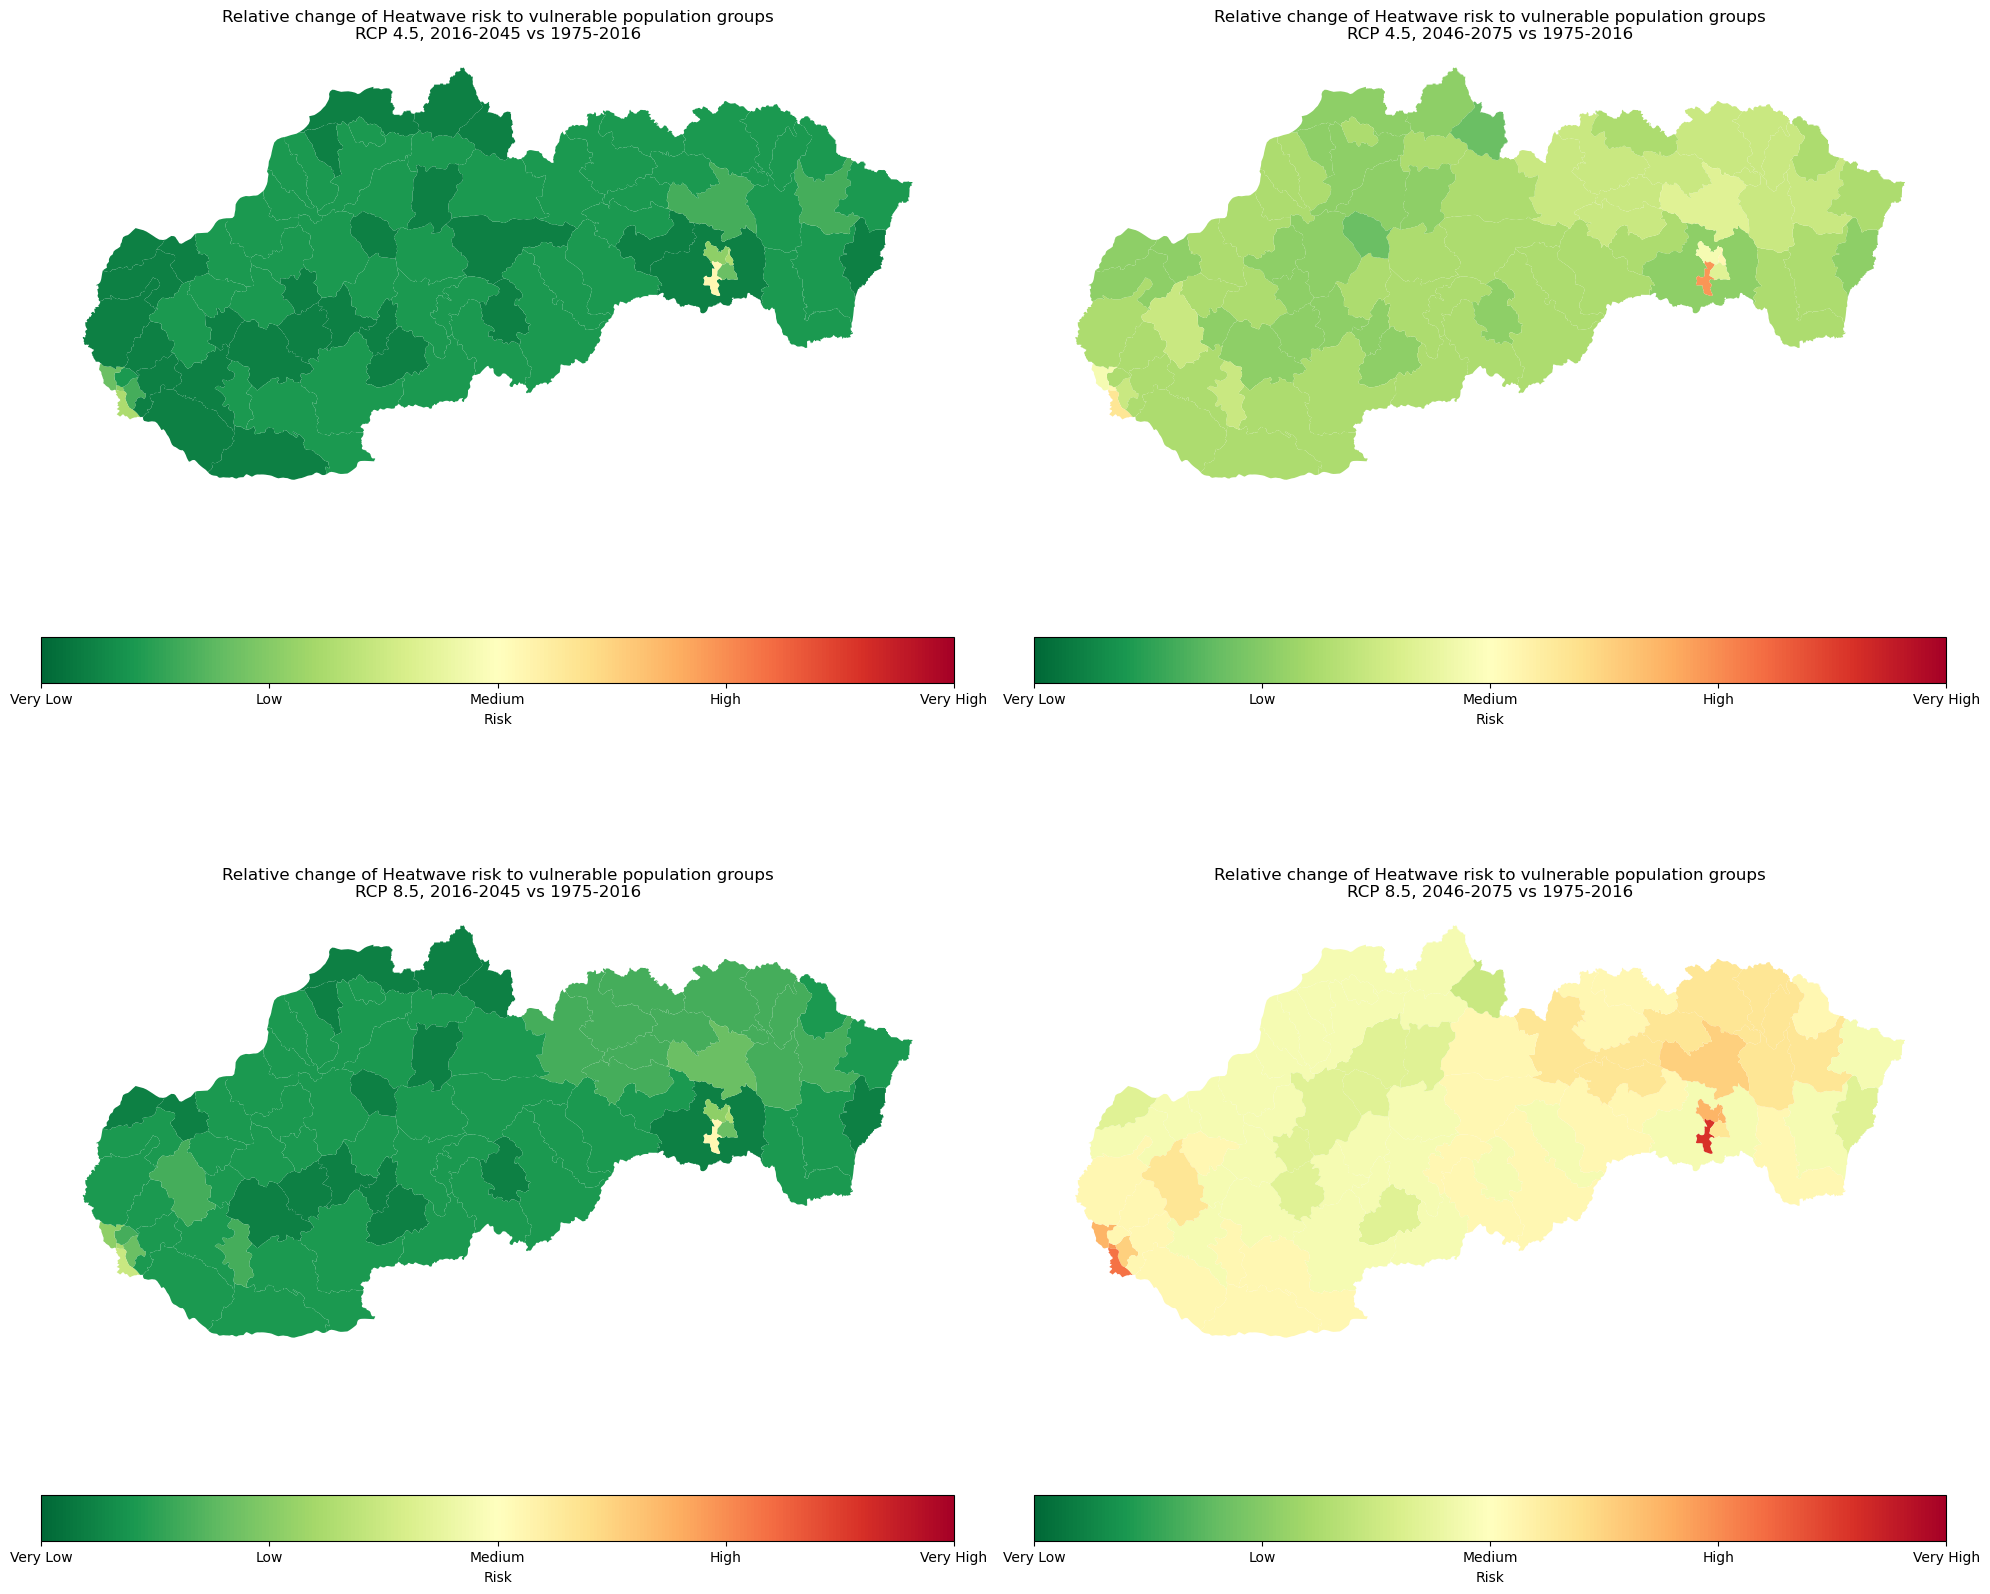

In [11]:
# List of the zonal statistics shapefiles
zonal_stats_files = [
    'sum_class_reclassified_relative_change_rcp45_2016_2045.shp',
    'sum_class_reclassified_relative_change_rcp45_2046_2075.shp',
    'sum_class_reclassified_relative_change_rcp85_2016_2045.shp', 
    'sum_class_reclassified_relative_change_rcp85_2046_2075.shp'
]

# Corresponding titles for the plots
titles = [
    'Relative change of Heatwave risk to vulnerable population groups\nRCP 4.5, 2016-2045 vs 1975-2016',
    'Relative change of Heatwave risk to vulnerable population groups\nRCP 4.5, 2046-2075 vs 1975-2016',
    'Relative change of Heatwave risk to vulnerable population groups\nRCP 8.5, 2016-2045 vs 1975-2016',
    'Relative change of Heatwave risk to vulnerable population groups\nRCP 8.5, 2046-2075 vs 1975-2016'
]

# Load all shapefiles into a list of GeoDataFrames
gdfs = [gpd.read_file(os.path.join(results_dir, file)) for file in zonal_stats_files]

# Get the global min and max of the 'sum_class' values
min_value = min(gdf['sum_class'].min() for gdf in gdfs)
max_value = max(gdf['sum_class'].max() for gdf in gdfs)

# Define the class intervals and labels
class_intervals = [1, 5.75, 10.5, 15.25, 20]
class_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Plot each shapefile
fig, axes = plt.subplots(2, 2, figsize=(20, 18))  # Changed to 2 rows and 2 columns
axes = axes.flatten()

for ax, gdf, title in zip(axes, gdfs, titles):
    plot = gdf.plot(column='sum_class', ax=ax, legend=True,
                    legend_kwds={'label': "Risk",
                                 'orientation': "horizontal",
                                 'ticks': class_intervals,
                                 'spacing': 'uniform',
                                 'format': lambda x, _: class_labels[class_intervals.index(x)] if x in class_intervals else ''},
                    vmin=1, vmax=20, cmap='RdYlGn_r')
    ax.set_title(title)
    ax.axis('off')

# Adjust the color bar manually to fit the intervals and labels
cbar = fig.get_axes()[-1]

plt.tight_layout()
plt.show()

The picture above shows the potential projected increase of the heatwave risk to vulnerable population groups among the selected regions. This result is based on the combination of the projected magnitude of change in the heatwave occurrence with the distribution of the vulnerable groups of the population. 

## Conclusion

**Results of this workflow provide information about the relative change in the heatwave occurrence, distribution of the vulnerable groups of the population, and projected heatwave risk for the vulnerable groups.** 

These results help to understand better the projected magnitudes of change in the heatwave occurrence and highlight the palaces with the higher density of the vulnerable groups of the population. In addition, this workflow shows the methodology of how we can combine these two information with the use of the 10+10 risk matrix. 

- The results show the heatwave risk estimation based on hazard and vulnerability data for future climate at a regional resolution.
  
- Hazard data were downloaded from the CDS based on the EUROheat heatwave occurrence for RCP 4.5 and 8.5 scenarios. This data has a resolution of 12x12 km.
  
- Vulnerability data were downloaded from Humdata and are based on WorldPop population density data for the year 2020. This data has a resolution of 100x100 meters.
  
- Since we combine the coarse-resolution hazard data with the high-resolution vulnerability data, we focus on comparisons at the regional level.

- Step 5. provide the information based on the combination of the magnitude of change in the heatwave occurrence with the distribution of the vulnerable groups of the population. 

## References

- humdata.org, High Resolution Population Density Maps + Demographic Estimates (2020), https://data.humdata.org/dataset/albania-high-resolution-population-density-maps-demographic-estimates [2024-06-20]
  
- Climate adapt, EuroHEATonline heat-wave forecast (2007), https://climate-adapt.eea.europa.eu/en/metadata/tools/euroheat-online-heatwave-forecast [2024-06-17]
  
- Copernicus Climate Data Store, Heat waves and cold spells in Europe derived from climate projections (2019), https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells?tab=overview [2024-06-17].
  
- GADM, shapefiles of the European regions (2018), https://gadm.org/download_country.html#google_vignette [2024-06-20]

## 6. Authors

- Martin Kuban, KAJO services (martin.kuban@kajoservices.com)
- Milan Kalas, KAJO services (milan.kalas@kajoservices.com)
- Natalia Aleksandrova, Deltares (review and editing)